In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_train = pd.read_csv('data/mnist_train.csv')
df_test = pd.read_csv('data/mnist_test.csv')

In [3]:
print(df_train.shape)
#print(df_test.shape)

(60000, 785)


In [4]:
df_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_features = df_train.iloc[:, 1:785]
df_label = df_train.iloc[:, 0]

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(df_features, df_label, 
                                                      test_size = 0.2,
                                                      random_state = 1234)

In [7]:
type(X_train)

pandas.core.frame.DataFrame

In [7]:
print(X_train.shape, X_valid.shape)

(48000, 784) (12000, 784)


In [8]:
X_train = np.array(X_train).reshape(48000, 784)
X_valid = np.array(X_valid).reshape(12000, 784)

In [9]:
X_train = X_train.reshape(48000, 1, 28, 28)
X_train  = torch.from_numpy(X_train).float()

y_train = torch.from_numpy(np.array(y_train))

In [10]:
print(X_train.shape, y_train.shape)

torch.Size([48000, 1, 28, 28]) torch.Size([48000])


In [11]:
X_valid = X_valid.reshape(12000, 1, 28, 28)
X_valid = torch.from_numpy(X_valid).float()

y_valid = torch.from_numpy(np.array(y_valid))

In [12]:
print(X_valid.shape, y_valid.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])


In [24]:
batch_size = 100

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train,y_train)
valid = torch.utils.data.TensorDataset(X_valid,y_valid)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = False)

In [25]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 5 * 5, 10) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        #Flatten
        out = out.view(out.size(0), -1)

        #Dense
        out = self.fc1(out)
        
        return out

model = CNNModel()

In [26]:
#Definition of hyperparameters
n_iters = 2500
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in valid_loader:
                
                valid = Variable(images.view(batch_size,1,28,28))
                # Forward propagation
                outputs = model(valid)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 10 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 10  Loss: 3.425729990005493  Accuracy: 49.57500076293945 %
Iteration: 20  Loss: 1.2844750881195068  Accuracy: 75.93333435058594 %
Iteration: 30  Loss: 0.5463815927505493  Accuracy: 82.5999984741211 %
Iteration: 40  Loss: 0.5336765050888062  Accuracy: 85.28333282470703 %
Iteration: 50  Loss: 0.7158792614936829  Accuracy: 87.16666412353516 %
Iteration: 60  Loss: 0.3922276794910431  Accuracy: 88.80000305175781 %
Iteration: 70  Loss: 0.39913418889045715  Accuracy: 89.50833129882812 %
Iteration: 80  Loss: 0.5098565816879272  Accuracy: 90.45833587646484 %
Iteration: 90  Loss: 0.4900376498699188  Accuracy: 91.01667022705078 %
Iteration: 100  Loss: 0.44428834319114685  Accuracy: 91.60832977294922 %
Iteration: 110  Loss: 0.25532302260398865  Accuracy: 92.04166412353516 %
Iteration: 120  Loss: 0.15693043172359467  Accuracy: 92.34166717529297 %
Iteration: 130  Loss: 0.3922934830188751  Accuracy: 92.54166412353516 %
Iteration: 140  Loss: 0.1997423768043518  Accuracy: 92.94999694824219 %

Iteration: 1150  Loss: 0.09660811722278595  Accuracy: 97.17500305175781 %
Iteration: 1160  Loss: 0.06977088749408722  Accuracy: 97.5250015258789 %
Iteration: 1170  Loss: 0.02667337656021118  Accuracy: 97.06666564941406 %
Iteration: 1180  Loss: 0.048454880714416504  Accuracy: 97.31666564941406 %
Iteration: 1190  Loss: 0.03584868088364601  Accuracy: 97.41666412353516 %
Iteration: 1200  Loss: 0.01780804432928562  Accuracy: 97.3499984741211 %
Iteration: 1210  Loss: 0.020733976736664772  Accuracy: 97.40833282470703 %
Iteration: 1220  Loss: 0.007931561209261417  Accuracy: 97.43333435058594 %
Iteration: 1230  Loss: 0.08628383278846741  Accuracy: 97.2249984741211 %
Iteration: 1240  Loss: 0.02130214124917984  Accuracy: 97.6500015258789 %
Iteration: 1250  Loss: 0.10651377588510513  Accuracy: 97.55833435058594 %
Iteration: 1260  Loss: 0.013969472609460354  Accuracy: 97.71666717529297 %
Iteration: 1270  Loss: 0.0446455292403698  Accuracy: 97.16666412353516 %
Iteration: 1280  Loss: 0.14697924256324

Iteration: 2270  Loss: 0.0693584755063057  Accuracy: 98.06666564941406 %
Iteration: 2280  Loss: 0.014932695776224136  Accuracy: 97.9749984741211 %
Iteration: 2290  Loss: 0.0243847519159317  Accuracy: 97.9749984741211 %
Iteration: 2300  Loss: 0.02597627229988575  Accuracy: 98.06666564941406 %
Iteration: 2310  Loss: 0.04306454956531525  Accuracy: 97.58333587646484 %
Iteration: 2320  Loss: 0.02579631842672825  Accuracy: 97.69166564941406 %
Iteration: 2330  Loss: 0.0373804084956646  Accuracy: 97.39167022705078 %
Iteration: 2340  Loss: 0.06942642480134964  Accuracy: 97.83333587646484 %
Iteration: 2350  Loss: 0.03533186763525009  Accuracy: 97.74166870117188 %
Iteration: 2360  Loss: 0.01451028324663639  Accuracy: 97.73332977294922 %
Iteration: 2370  Loss: 0.024003226310014725  Accuracy: 97.93333435058594 %
Iteration: 2380  Loss: 0.10085420310497284  Accuracy: 97.79166412353516 %
Iteration: 2390  Loss: 0.08786043524742126  Accuracy: 97.78333282470703 %
Iteration: 2400  Loss: 0.1269356012344360

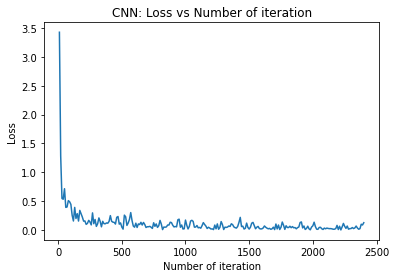

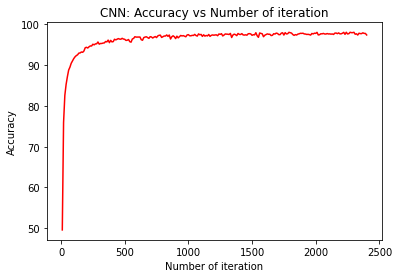

In [28]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [30]:
model.state_dict()

OrderedDict([('cnn1.weight',
              tensor([[[[-0.3047,  0.0198,  0.0376],
                        [ 0.1286, -0.2112,  0.1664],
                        [ 0.2683, -0.0097, -0.2110]]],
              
              
                      [[[-0.2136, -0.1231,  0.2049],
                        [-0.1068,  0.2587,  0.1828],
                        [-0.1782,  0.2310,  0.0477]]],
              
              
                      [[[-0.0277, -0.1865, -0.1670],
                        [ 0.0209,  0.1901,  0.3284],
                        [ 0.0760, -0.1812, -0.1864]]],
              
              
                      [[[-0.2505,  0.1366,  0.0503],
                        [ 0.1073, -0.1367, -0.0953],
                        [-0.2675,  0.2727, -0.0996]]],
              
              
                      [[[-0.2406, -0.0847, -0.2684],
                        [ 0.2863, -0.2348, -0.0872],
                        [ 0.1754,  0.3017, -0.0501]]],
              
              
                

In [31]:
# Test the model
df_test_features = df_test.iloc[:, 1:785]
df_test_label = df_test.iloc[:, 0]

X_test = df_test_features.to_numpy()
y_test = df_test_label.to_numpy()

In [34]:
sample = 10
img = X_test[sample] #shape (784,1)
img = img.reshape(1, 1, 28, 28) #shape (1,1,28,28)
img  = torch.from_numpy(img).float() #tensor

prediction = model(img).detach().numpy()[0].argmax()
print(prediction)

0


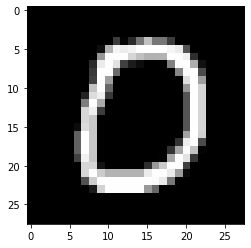

In [35]:
fig = plt.figure
plt.imshow(X_test[sample].reshape(28,28), cmap='gray')
plt.show()

In [38]:
# Save model state
torch.save(model.state_dict(), 'models/mnist_cnn.pt')